This notebook convolves the native COPT files to 150pc resolution

In [1]:
# import statements
from collections import OrderedDict
import sys, glob

import numpy as np
import pandas as pd
import scipy.stats
from scipy.odr import ODR, Model, Data, RealData

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.stats import mad_std
from astropy.constants import iau2012 as const
from astropy.convolution import convolve_fft, Gaussian2DKernel

from scipy.interpolate import RegularGridInterpolator
from reproject import reproject_interp

import matplotlib.pyplot as plt

from scipy.stats import spearmanr, gaussian_kde
# from utils_stats import *

In [2]:
# convolving functions

def make_gaussian_psf(fwhm_arcsec = 1.0, oversample_by=10., outfile=None):
    """Adapted from Francesco Belfiore / Tom Williams. Could/should
    replace with radio_beam and spectral cube calculations for a full
    to/from infrastructure.

    Should add an option to force the PSF size.
    """

    pix_size_arcsec = fwhm_arcsec / oversample_by
    std_pix = fwhm_arcsec / 2.355 / pix_size_arcsec
    
    gauss_2d = Gaussian2DKernel(x_stddev=std_pix)
    
    psf_array = fits.PrimaryHDU(data=np.array(gauss_2d.array, dtype=np.float32))
    
    psf_array.header['BITPIX'] = -32
    
    psf_array.header['CRPIX1'] = (gauss_2d.array.shape[1] + 1) / 2
    psf_array.header['CRPIX2'] = (gauss_2d.array.shape[0] + 1) / 2
    
    psf_array.header['CRVAL1'] = 0.00
    psf_array.header['CRVAL2'] = 0.00
    
    psf_array.header['CDELT1'] = - pix_size_arcsec / 3600
    psf_array.header['CDELT2'] = pix_size_arcsec / 3600

    psf_array.header['CTYPE1'] = 'RA---TAN'
    psf_array.header['CTYPE2'] = 'DEC--TAN'

    if outfile is not None:
        psf_array.writeto(outfile)
        
    return(psf_array)

def get_pixscale(hdu):
    """From Tom Williams. Get pixel scale from header. Checks HDU header
    for pixel scale keywords, and returns a pixel scale in arcsec. If
    no suitable keyword is found, will throw up an error. From Tom
    Williams.

    Args:

        hdu (astropy.fits.PrimaryHDU): HDU to get pixel scale for.

    Returns:

        pix_scale (float): Pixel scale in arcsec.

    Raises:

        Warning: If no suitable pixel scale keyword is found in header.

    Author:

    Tom Williams

    """

    PIXEL_SCALE_NAMES = ['XPIXSIZE', 'CDELT1', 'CD1_1', 'PIXELSCL']

    for pixel_keyword in PIXEL_SCALE_NAMES:
        try:
            try:
                pix_scale = np.abs(float(hdu.header[pixel_keyword]))
            except ValueError:
                continue
            if pixel_keyword in ['CDELT1', 'CD1_1']:
                pix_scale *= 3600
            return pix_scale
        except KeyError:
            pass

    raise Warning('No pixel scale found')

def conv_with_kernel(image_hdu, kernel_hdu,
                     blank_zeros=True, set_zeros_to=np.nan,
                     allow_huge=True, preserve_nan=True, nan_treatment='interpolate',
                     outfile=None, overwrite=True):
    """Convolves in input image with an input kernel, both HDUs, and
    returns a new HDU or optionally writes to disk. From Tom Williams,
    refactored into general routine.
    """

    # Set zero values to NaN (or another user-specified value), which
    # astropy convolution handles with interpolation.
    if blank_zeros:
        image_hdu.data[image_hdu.data == 0] = set_zeros_to

    # Get the pixel scale of the image and the kernel
    
    image_pix_scale = get_pixscale(image_hdu)    
    kernel_pix_scale = get_pixscale(kernel_hdu)

    # Note the shape and grid of the kernel as input
    
    kernel_hdu_length = kernel_hdu.data.shape[0]            
    original_central_pixel = (kernel_hdu_length - 1) / 2            
    original_grid = (np.arange(kernel_hdu_length) - original_central_pixel) * kernel_pix_scale

    # Calculate kernel size after interpolating to the image pixel
    # scale. Because sometimes there's a little pixel scale rounding
    # error, subtract a little bit off the optimum size (Tom
    # Williams).
            
    interpolate_kernel_size = np.floor(kernel_hdu_length * kernel_pix_scale / image_pix_scale) - 2

    # Ensure the kernel has a central pixel
    
    if interpolate_kernel_size % 2 == 0:
        interpolate_kernel_size -= 1

    # Define a new coordinate grid onto which to project the kernel
    # but using the pixel scale of the image
    
    new_central_pixel = (interpolate_kernel_size - 1) / 2            
    new_grid = (np.arange(interpolate_kernel_size) - new_central_pixel) * image_pix_scale
    x_coords_new, y_coords_new = np.meshgrid(new_grid, new_grid)

    # Do the reprojection from the original kernel grid onto the new
    # grid with pixel scale matched to the image
    
    grid_interpolated = RegularGridInterpolator((original_grid, original_grid), kernel_hdu.data)
    kernel_interp = grid_interpolated((x_coords_new.flatten(), y_coords_new.flatten()))
    kernel_interp = kernel_interp.reshape(x_coords_new.shape)
            
    # Now with the kernel centered and matched in pixel scale to the
    # input image use the FFT convolution routine from astropy to
    # convolve.
    
    image_data_convolved = convolve_fft(image_hdu.data, kernel_interp,
                                        allow_huge=allow_huge, preserve_nan=preserve_nan,
                                        normalize_kernel=True,
                                        nan_treatment=nan_treatment)
    
    # Form into an HDU
    input_hdu_convolved = fits.PrimaryHDU(image_data_convolved, image_hdu.header)

    # If an output file name is supplied write to disk 
    
    if outfile is not None:
        input_hdu_convolved.writeto(outfile, overwrite=overwrite)

    return(input_hdu_convolved)

In [4]:
# read in SNeHa data
data = pd.read_csv("../Data/0.MUSEdata.csv")

nat_files = data['maps_nat']
distances = data['Distance']
native_res = data['MUSE_nat_res']

data[0:1]


,Galaxy,Distance,Gal_ra,Gal_dec,Pos_ang,Incl,MUSE_nat_res,MUSE_phys_res,maps_nat,maps_15asec,maps_150,maps_1kpc,maps_HII,maps_irac,maps_CO21,maps_eCO21
0,IC5332,9.01,353.61453,-36.10108,74.4,26.9,0.87,45,../../GalaxyFiles/MUSELargeFiles/SFR/copt/IC53...,../../GalaxyFiles/MUSELargeFiles/SFR/15asec/IC...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/IC53...,../../GalaxyFiles/MUSELargeFiles/SFR/copt/IC53...,../Data/HII_reg_masks/IC5332_nebulae_mask_V2.fits,../Data/IRAC/ic5332_irac1_atGauss4.fits,../../GalaxyFiles/ALMACO2-1/ic5332_12m+7m+tp_c...,../../GalaxyFiles/ALMACO2-1/ic5332_12m+7m+tp_c...


In [5]:
# function for converting native resolution to 150pc resolution

def find_fwhm_from_physical_res(distance_mpc, physical_res):
    
    distance_pc = distance_mpc * 10**6
    fwhm_asec = physical_res * 206265. /  distance_pc 
    
    return(fwhm_asec)

fwhm_at_150pc = find_fwhm_from_physical_res(distances, 150.0)
fwhm_at_1kpc  = find_fwhm_from_physical_res(distances, 1000.0)


In [7]:
#convolve the files and save

k_hdus, orig_hdus, conv_hdus = [],[],[]

for i in range(len(nat_files)):

    this_fwhm = fwhm_at_150pc[i]
    fwhm_first_gauss = native_res[i]
    this_oversamp = 50.

    
        
    kernel_hdu = make_gaussian_psf(fwhm_arcsec = np.sqrt(this_fwhm**2-(fwhm_first_gauss)**2),
                        oversample_by=this_oversamp, outfile=None)
    k_hdus.append(kernel_hdu.data)
    
    hdulist = fits.open(nat_files[i])
    convolved_hdu = hdulist["HA_FLUX_CORR"]
    orig_hdus.append(convolved_hdu.data)

    output_file_name = nat_files[i][:-5] + '_150pc.fits'
    
    convolved_more_hdu = conv_with_kernel(
                        convolved_hdu, kernel_hdu,
                        outfile=output_file_name, overwrite=True)
    conv_hdus.append(convolved_more_hdu.data)
    
    convolved_more_hdu.writeto(output_file_name, overwrite=True)
        

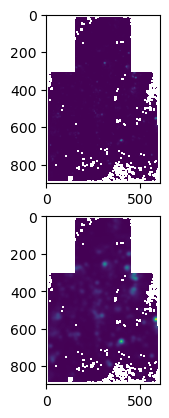

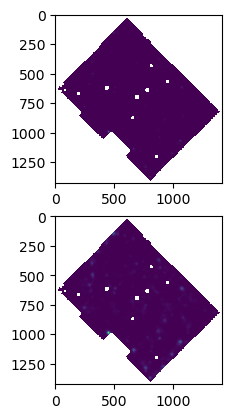

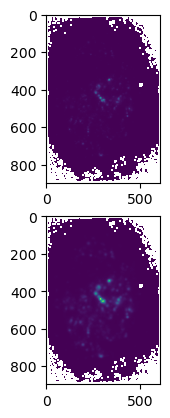

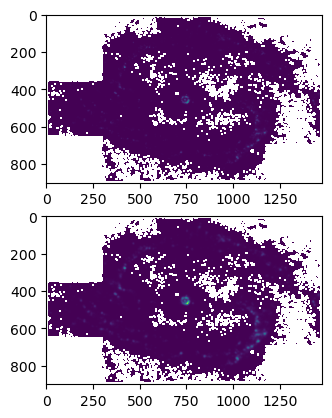

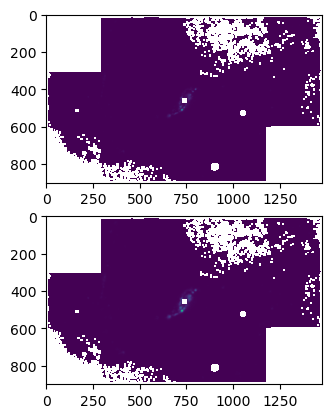

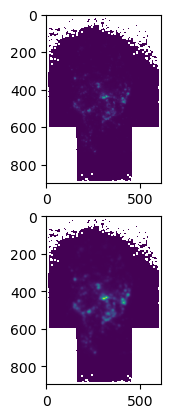

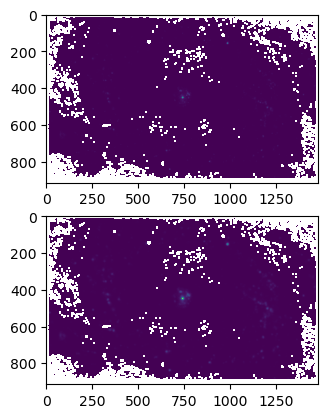

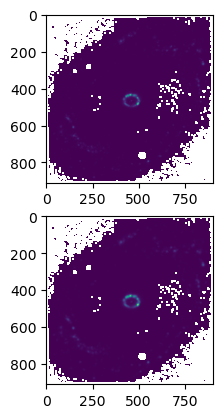

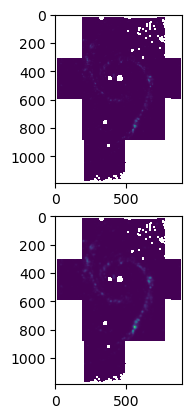

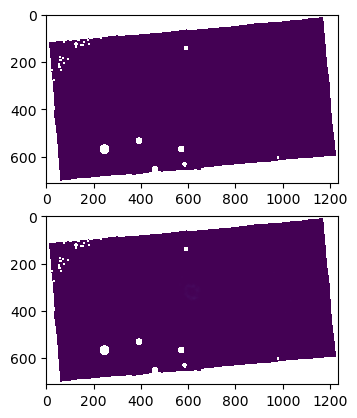

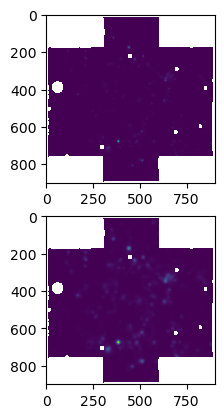

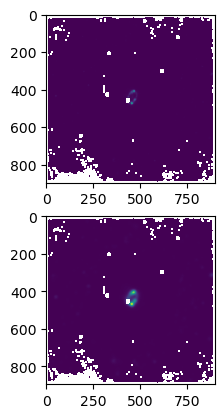

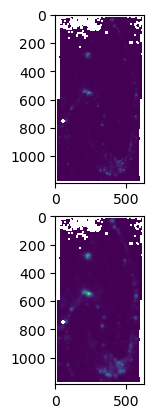

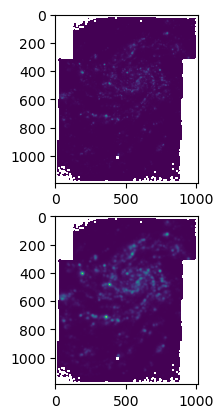

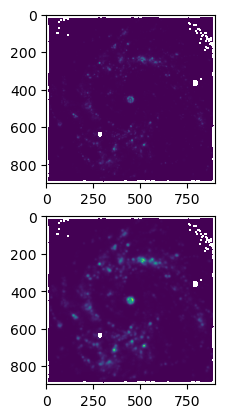

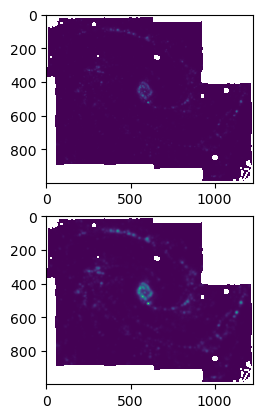

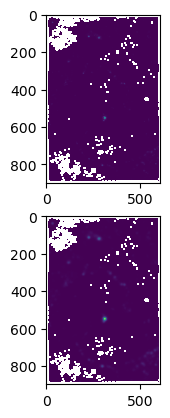

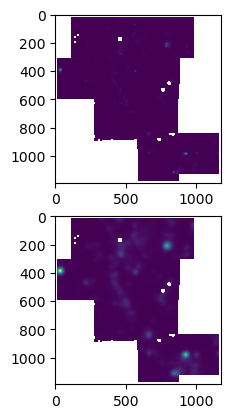

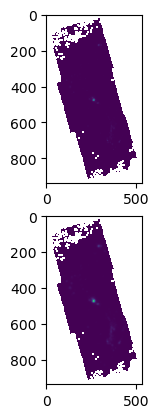

In [9]:
#imshow the files to check

for i in range(len(nat_files)):
    fig,ax = plt.subplots(2,1)
    ax[0].imshow(orig_hdus[i])
    ax[1].imshow(conv_hdus[i])


In [10]:
#convolve the files and save

k_hdus, orig_hdus, conv_hdus = [],[],[]

for i in range(len(nat_files)):

    this_fwhm = native_res[i]
    fwhm_first_gauss = fwhm_at_1kpc[i]
    this_oversamp = 200
        
#     print(this_fwhm, fwhm_first_gauss)
    kernel_hdu = make_gaussian_psf(fwhm_arcsec = fwhm_at_1kpc[i],
#                         fwhm_arcsec = np.sqrt(this_fwhm**2-(fwhm_first_gauss)**2),
                        oversample_by=this_oversamp, outfile=None)
    k_hdus.append(kernel_hdu.data)
    hdulist = fits.open(nat_files[i])
    convolved_hdu = hdulist["HA_FLUX_CORR"]
    orig_hdus.append(convolved_hdu.data)

    output_file_name = nat_files[i][:-5] + '_1kpc.fits'
    
    convolved_more_hdu = conv_with_kernel(
                        convolved_hdu, kernel_hdu,
                        outfile=output_file_name, overwrite=True)
    conv_hdus.append(convolved_more_hdu.data)
    
    convolved_more_hdu.writeto(output_file_name, overwrite=True)
        

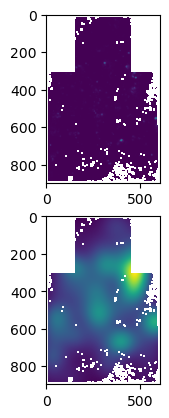

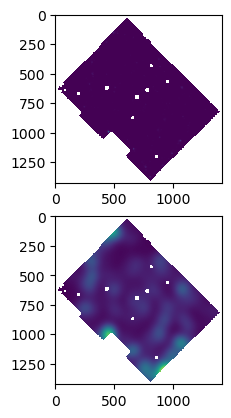

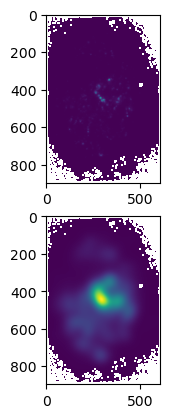

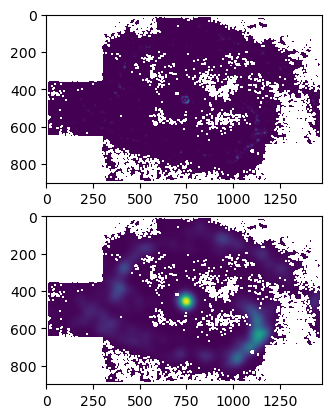

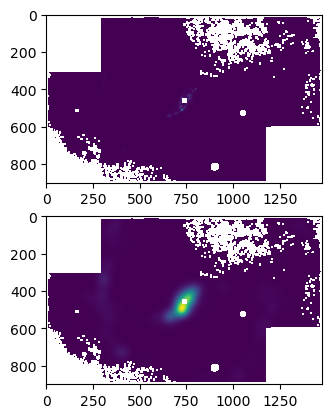

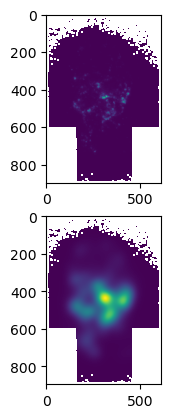

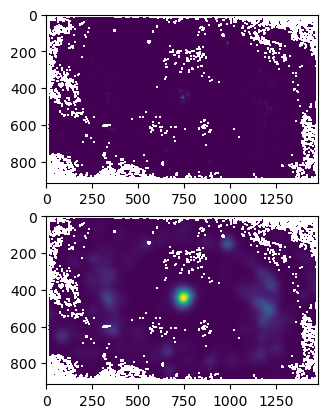

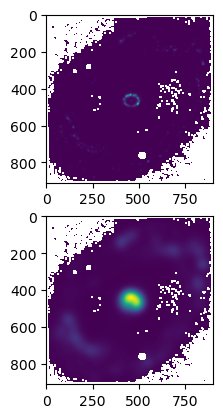

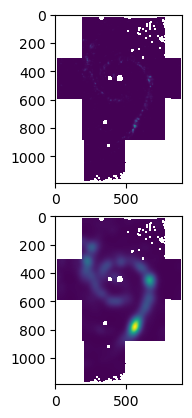

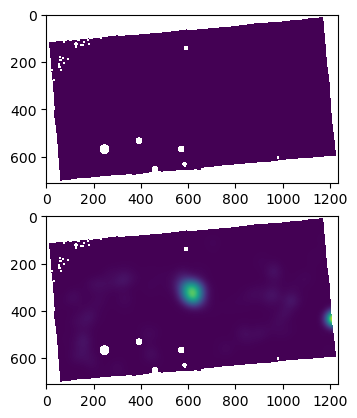

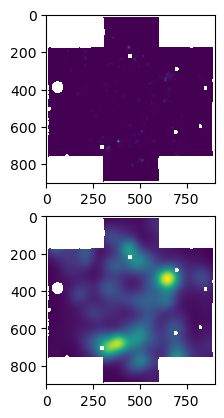

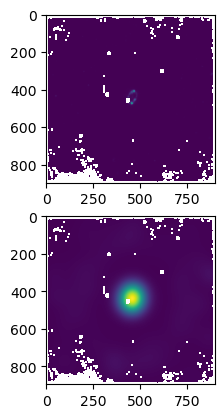

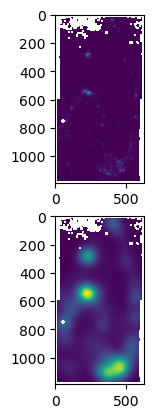

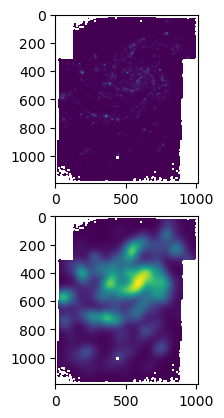

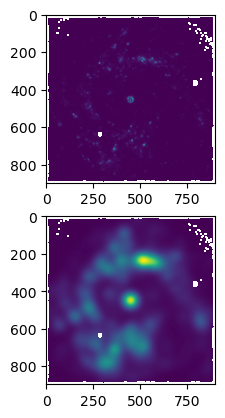

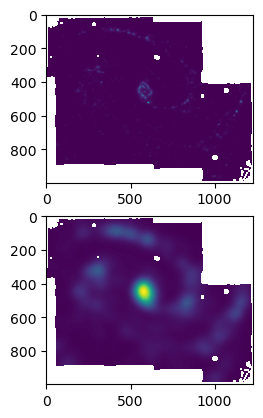

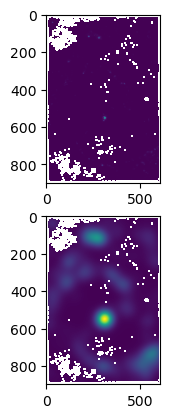

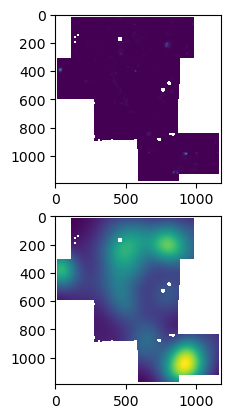

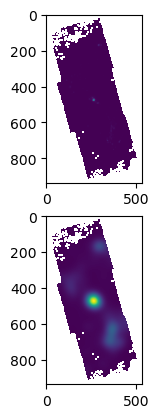

In [11]:
#imshow the files to check

for i in range(len(nat_files)):
    fig,ax = plt.subplots(2,1)
    ax[0].imshow(orig_hdus[i])
    ax[1].imshow(conv_hdus[i])